In [1]:
%matplotlib inline
from lynxes.model import DeployedModel
from lynxes.model import InMemoryModel
from lynxes.core.explanations import Interpretation
import pandas as pd
import numpy as np
import json
import requests
np.random.seed(1)
from __future__ import print_function

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
def input_formatter(data):
    # Convert a data frame of the format 
    #     Status.of.existing.checking.account  Duration.in.month Credit.history Savings.account.bonds 
    # 0                                 A11                  6            A34            A65
    # 1                                 A12                 48            A32            A61 
    # to the following format:
    # {"input":[{"Status.of.existing.checking.account": "A11", "Duration.in.month": 24, "Credit.history": "A32", 
    # "Savings.account.bonds": "A63"}, {"Status.of.existing.checking.account": "A12", "Duration.in.month": 23, 
    # "Credit.history": "A31", "Savings.account.bonds": "A65"}, {"Status.of.existing.checking.account": "A12", 
    # "Duration.in.month": 23, "Credit.history": "A31", "Savings.account.bonds": "A65"}]}
    #if not isinstance(data, pd.DataFrame):
    #        raise TypeError("must be a dataframe")
    return {"input": pd.DataFrame(data).to_json(orient='records')}
    
def output_formatter(response, key='probability'):
    return np.array(response.json()['probability'])

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
feature_name = ['Status of existing checking account', 'Duration in month', 'Credit history'
, 'Purpose', 'Credit amount', 'Savings account.bonds', 'Employment years'
, 'Installment rate in percentage of disposable income'
, 'Personal status and sex', 'Other debtors.guarantors', 'Present residence since'
, 'Property', 'Age in years', 'Other installment plans', 'Housing', 'Number of existing credits at this bank'
, 'Job', 'Number of people being liable to provide maintenance for', 'Telephone', 'Foreign worker', 'Status']

f_n = [f.replace(' ', '.') for f in feature_name]
input_data = pd.read_csv(url, sep=' ', names=f_n)
input_data.head(1)

,Status.of.existing.checking.account,Duration.in.month,Credit.history,Purpose,Credit.amount,Savings.account.bonds,Employment.years,Installment.rate.in.percentage.of.disposable.income,Personal.status.and.sex,Other.debtors.guarantors,...,Property,Age.in.years,Other.installment.plans,Housing,Number.of.existing.credits.at.this.bank,Job,Number.of.people.being.liable.to.provide.maintenance.for,Telephone,Foreign.worker,Status
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1


In [4]:
deployed_model_uri = "http://datsci.dev:8000/predict"

In [5]:
# Filter on the features as needed by the model
selected_input_data = input_data[['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 
                                  'Savings.account.bonds']]
#print(type(selected_input_data.values))
print(selected_input_data.head(2))
#input_formatter(selected_input_data.values)
print(type(selected_input_data))

  Status.of.existing.checking.account  Duration.in.month Credit.history  \
0                                 A11                  6            A34   
1                                 A12                 48            A32   

  Savings.account.bonds  
0                   A65  
1                   A61  
<class 'pandas.core.frame.DataFrame'>


In [6]:
# Convert the dataframe to the following the required format:
input_data = input_formatter(selected_input_data.head(5))
print(input_data['input'])

[{"Status.of.existing.checking.account":"A11","Duration.in.month":6,"Credit.history":"A34","Savings.account.bonds":"A65"},{"Status.of.existing.checking.account":"A12","Duration.in.month":48,"Credit.history":"A32","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A14","Duration.in.month":12,"Credit.history":"A34","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A11","Duration.in.month":42,"Credit.history":"A32","Savings.account.bonds":"A61"},{"Status.of.existing.checking.account":"A11","Duration.in.month":24,"Credit.history":"A33","Savings.account.bonds":"A61"}]


In [7]:
dep_model = DeployedModel(deployed_model_uri,
                         input_formatter,
                         output_formatter,
                         examples=selected_input_data.head(5))

2017-05-02 21:59:22,485 - lynxes.core.explanations - INFO - Loading Data
2017-05-02 21:59:22,486 - lynxes.data.dataset - DEBUG - __init__ data.shape: (5, 4)
2017-05-02 21:59:22,486 - lynxes.data.dataset - DEBUG - after transform data.shape: (5, 4)
2017-05-02 21:59:22,489 - lynxes.core.explanations - INFO - Data loaded
2017-05-02 21:59:22,490 - lynxes.core.explanations - DEBUG - Data shape: (5, 4)
2017-05-02 21:59:22,491 - lynxes.core.explanations - DEBUG - Dataset Feature_ids: ['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 'Savings.account.bonds']
2017-05-02 21:59:22,495 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 3)]
2017-05-02 21:59:22,496 - lynxes.core.explanations - DEBUG - Grid shape used for pdp: (1, 3)
2017-05-02 21:59:22,497 - lynxes.core.explanations - DEBUG - Grid resolution for pdp: 10
2017-05-02 21:59:22,499 - lynxes.data.dataset - DEBUG - Generating sample with args:
 {'n_samples_from_dataset': 500, 'replace': True, 'sample':

[[<matplotlib.figure.Figure at 0x7f6125785d50>,

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


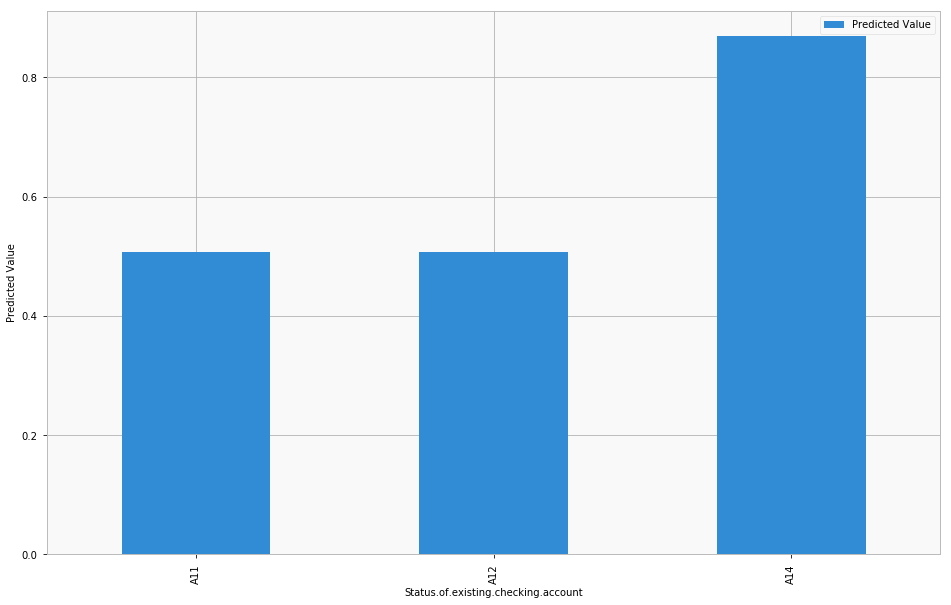

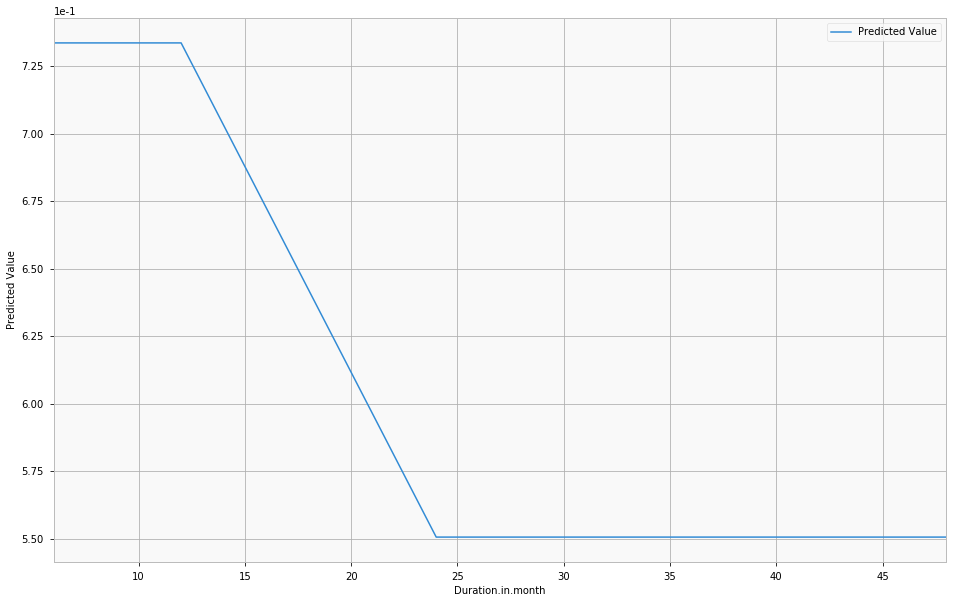

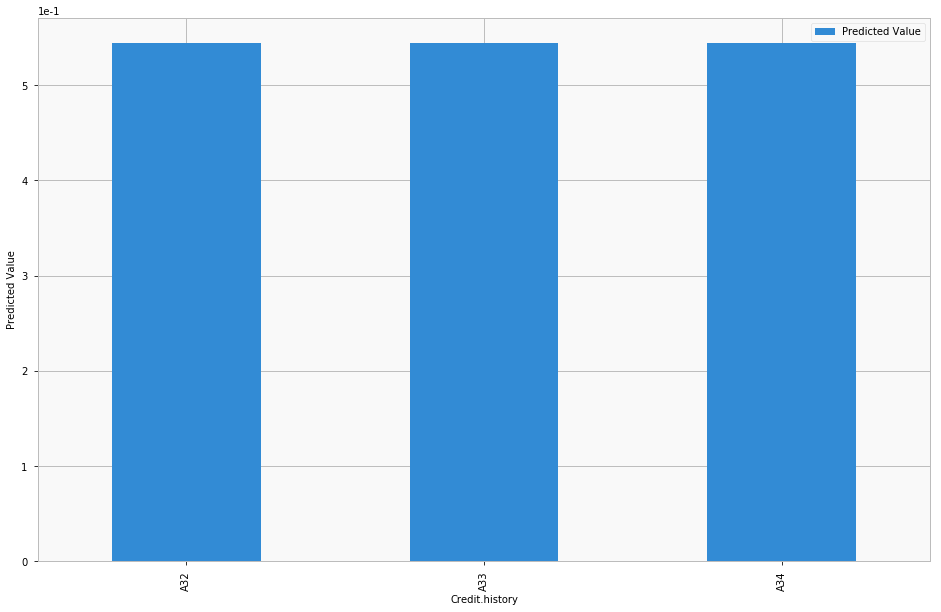

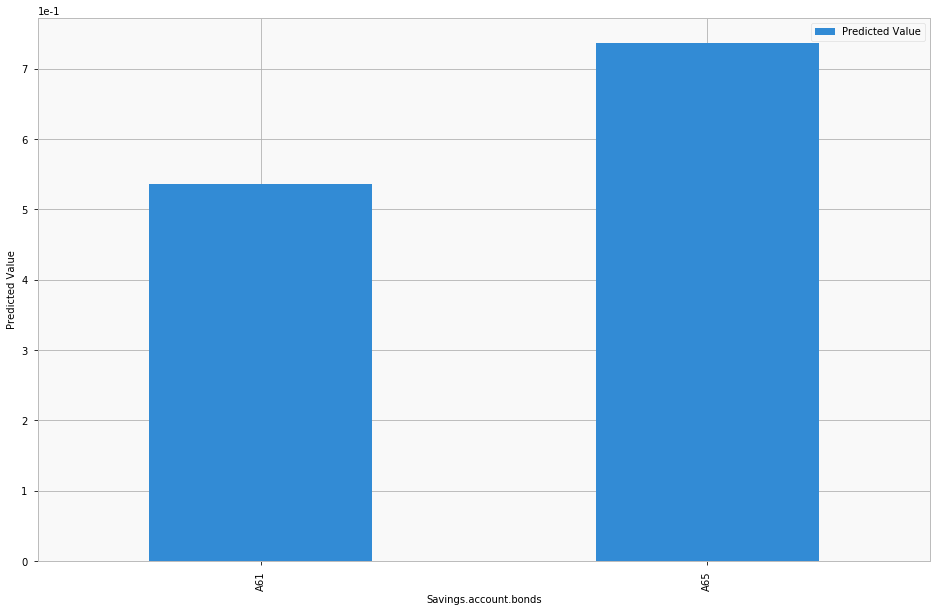

In [8]:
feature_names = np.array(selected_input_data.columns)
interpreter = Interpretation(log_level=10)
interpreter.load_data(selected_input_data.head(5), feature_names=feature_names)

interpreter.partial_dependence.plot_partial_dependence(interpreter.data_set.feature_ids,
                                                         dep_model,
                                                         with_variance=False, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

In [9]:
interpreter.data_set.feature_info
[('Credit.history','Savings.account.bonds')]

{'Credit.history': {'numeric': False, 'type': dtype('O'), 'unique': 3},
 'Duration.in.month': {'numeric': True, 'type': dtype('int64'), 'unique': 5},
 'Savings.account.bonds': {'numeric': False, 'type': dtype('O'), 'unique': 2},
 'Status.of.existing.checking.account': {'numeric': False,
  'type': dtype('O'),
  'unique': 3}}

In [9]:
f_2_1 = 'Savings.account.bonds'
f_3_1 = 'Credit.history'
f_3_2 = 'Status.of.existing.checking.account'
f_cont_1 = "Duration.in.month"


2017-05-02 21:59:30,287 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 2), (1, 3)]
2017-05-02 21:59:30,288 - lynxes.core.explanations - DEBUG - Grid shape used for pdp: (2,)
2017-05-02 21:59:30,289 - lynxes.core.explanations - DEBUG - Grid resolution for pdp: 10
2017-05-02 21:59:30,289 - lynxes.data.dataset - DEBUG - Generating sample with args:
 {'n_samples_from_dataset': 500, 'replace': True, 'sample': True, 'samples_per_bin': 10, 'strategy': 'random-choice', 'bin_count': 50}
2017-05-02 21:59:30,290 - lynxes.core.explanations - DEBUG - Shape of sampled data: (500, 4)
2017-05-02 21:59:30,291 - lynxes.core.explanations - DEBUG - Feature Ids: ('Savings.account.bonds', 'Status.of.existing.checking.account')
2017-05-02 21:59:30,291 - lynxes.core.explanations - DEBUG - PD metadata: {'data_feature_ids': ['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 'Savings.account.bonds'], 'class_columns': ['Predicted Value'], 'feature_columns': ['Savings.accou

Status.of.existing.checking.account       A11       A12     A14
Savings.account.bonds                                          
A61                                  0.506140  0.506140  0.8687
A65                                  0.701981  0.701981  0.8687


[[<matplotlib.figure.Figure at 0x7f61244b1b10>,

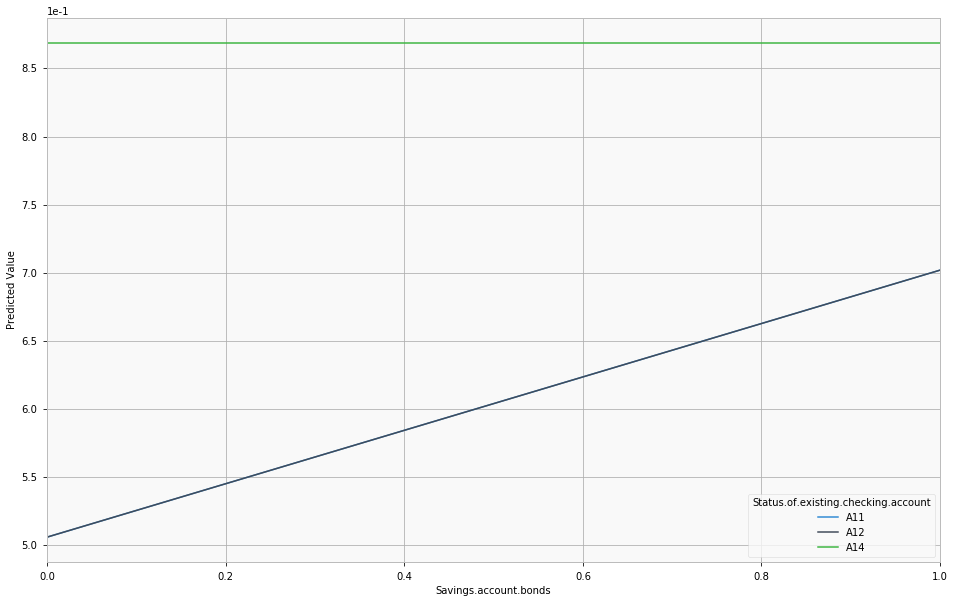

In [10]:
interpreter.partial_dependence.plot_partial_dependence([(f_2_1, f_3_2)],
                                                         dep_model,
                                                         with_variance=False, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

2017-05-02 22:00:42,474 - lynxes.data.dataset - INFO - Generated grid of shape [(1, 3), (1, 5)]
2017-05-02 22:00:42,475 - lynxes.core.explanations - DEBUG - Grid shape used for pdp: (2,)
2017-05-02 22:00:42,476 - lynxes.core.explanations - DEBUG - Grid resolution for pdp: 10
2017-05-02 22:00:42,476 - lynxes.data.dataset - DEBUG - Generating sample with args:
 {'n_samples_from_dataset': 500, 'replace': True, 'sample': True, 'samples_per_bin': 10, 'strategy': 'random-choice', 'bin_count': 50}
2017-05-02 22:00:42,479 - lynxes.core.explanations - DEBUG - Shape of sampled data: (500, 4)
2017-05-02 22:00:42,479 - lynxes.core.explanations - DEBUG - Feature Ids: ('Status.of.existing.checking.account', 'Duration.in.month')
2017-05-02 22:00:42,480 - lynxes.core.explanations - DEBUG - PD metadata: {'data_feature_ids': ['Status.of.existing.checking.account', 'Duration.in.month', 'Credit.history', 'Savings.account.bonds'], 'class_columns': ['Predicted Value'], 'feature_columns': ['Status.of.existin

[[<matplotlib.figure.Figure at 0x7f6124142790>,

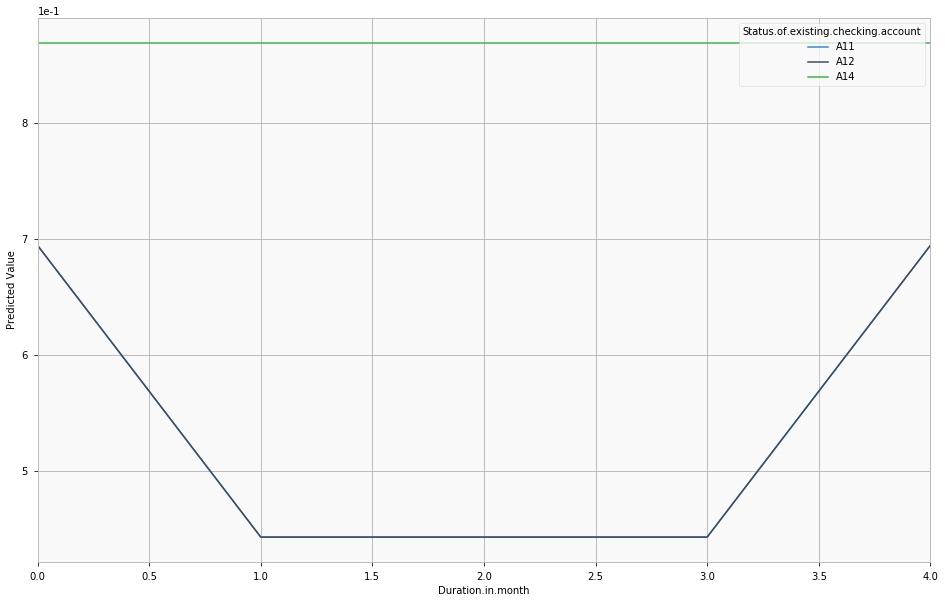

In [13]:
interpreter.partial_dependence.plot_partial_dependence([(f_3_2, f_cont_1)],
                                                         dep_model,
                                                         with_variance=False, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)

[[<matplotlib.figure.Figure at 0x7f15d2769190>,

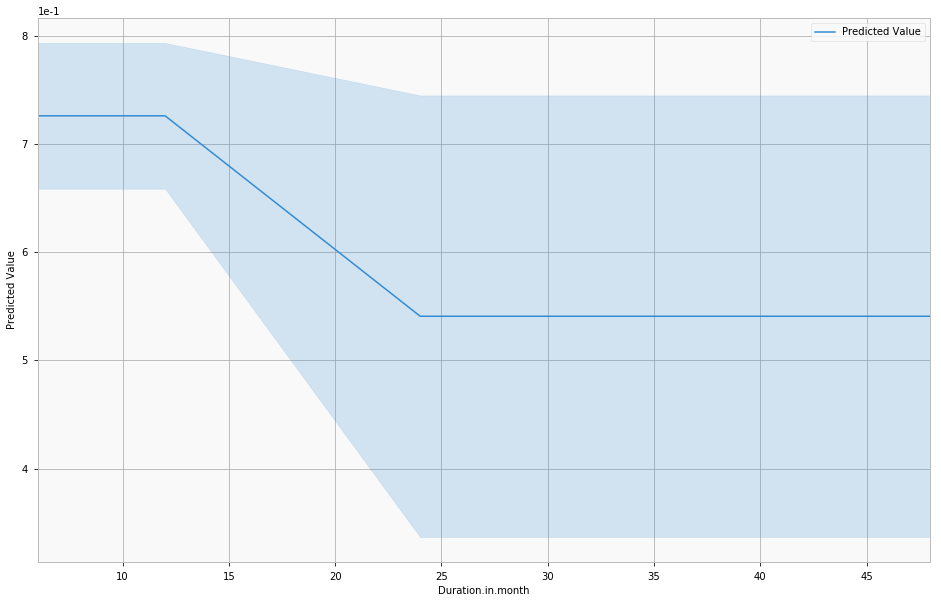

In [11]:

feature_names = np.array(selected_input_data.columns)
interpreter = Interpretation()
interpreter.load_data(selected_input_data.head(5), feature_names=feature_names)

interpreter.partial_dependence.plot_partial_dependence(['Duration.in.month'],
                                                         dep_model,
                                                         with_variance=True, 
                                                         sampling_strategy='random-choice',
                                                         n_jobs=4, grid_resolution=10, n_samples = 500, sample=True)